In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

/Users/limingxuan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/limingxuan/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [24]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transition = random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done = zip(*transition)  #用于将迭代器解压缩为多个独立的迭代器
        return np.array(state),action,reward,np.array(next_state),done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [37]:
#基于非图像的状态输入
class Qnet(torch.nn.Module):
    # 只有一层隐藏层的Q网络
    def __init__(self,dim_state,dim_hidden,dim_action):
        super(Qnet,self).__init__()
        self.fc1 = torch.nn.Linear(dim_state,dim_hidden)
        self.fc2 = torch.nn.Linear(dim_hidden,dim_action)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [38]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, dim_state,dim_hidden,dim_action,lr,gamma,epsilon,target_update,device):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.q_net = Qnet(dim_state, dim_hidden, dim_action).to(device)
        self.target_q_net = Qnet(dim_state, dim_hidden, dim_action).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.dim_action)
        else:
            state = torch.tensor([state],dtype=torch.float).to(device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1,1).to(device)

        q_vals = self.q_net(states).gather(1,actions)
        next_q_max_vals = self.target_q_net(next_states).max(1)[0].view(-1,1)
        q_targets = rewards + gamma*next_q_max_vals*(1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_vals,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count%self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1

In [39]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)     #gym需要在0.25以下
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            env.reset()
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state,action,reward,next_state,done)
                state = next_state
                episode_return += reward
                if replay_buffer.size() > minimal_size:
                    b_s,b_a,b_r,b_ns,b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states':b_s,
                        'actions':b_a,
                        'rewards':b_r,
                        'next_states':b_ns,
                        'dones':b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1)%10 == 0:
                pbar.set_postfix({
                    'episode':'%d'%(num_episodes/10 * i + i_episode + 1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, episode=500, return=200.000]


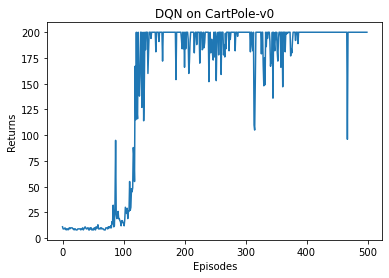

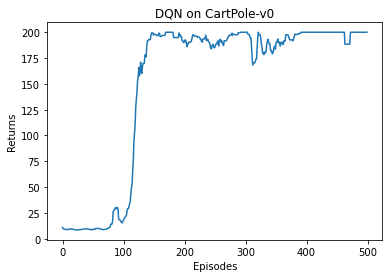

In [30]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()